# Cleaning LST GeoTIFF Files

In [1]:
# Import libraries
import os
import glob
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt

In [2]:
# Set input directory, and change working directory
inDir = 'D:\Files\School\COMP_490_Senior_Design\Beat-the-Heat\Datasets\LST_BA' # IMPORTANT: Update to reflect directory on your OS
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [3]:
LST_Day = glob.glob('MOD11A1.006_LST_Day_1km**.tif')

In [4]:
LST = gdal.Open(LST_Day[0])                    # Read file in, starting with MOD13Q1 version 6
LSTBand = LST.GetRasterBand(1)                  # Read the band (layer)
LSTData = LSTBand.ReadAsArray().astype('float') # Import band as an array with type float

In [5]:
print(LST_Day[0])

MOD11A1.006_LST_Day_1km_doy2019001_aid0001.tif


In [6]:
# File name metadata:
productId = LST_Day[0].split('_')[0]                                          # First: product name
layerId = LST_Day[0].split(productId + '_')[1].split('_doy')[0]               # Second: layer name
yeardoy = LST_Day[0].split(layerId+'_doy')[1].split('_aid')[0]                # Third: date
aid = LST_Day[0].split(yeardoy+'_')[1].split('.tif')[0]                       # Fourth: unique ROI identifier (aid)
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m/%d/%Y')              # Convert YYYYDDD to MM/DD/YYYY
print('Product Name: {}\nLayer Name: {}\nDate of Observation: {}'.format(productId, layerId, date))

Product Name: MOD11A1.006
Layer Name: LST_Day_1km
Date of Observation: 01/01/2019


In [7]:
# File Metadata
LST_Day_meta = LST.GetMetadata()                   # Store metadata in dictionary
rows, cols = LST.RasterYSize, LST.RasterXSize  # Number of rows,columns

# Projection information
geotransform = LST.GetGeoTransform()
proj= LST.GetProjection() 

# Band metadata
LSTFill = LSTBand.GetNoDataValue()            # Returns fill value
LSTStats = LSTBand.GetStatistics(True, True)  # returns min, max, mean, and standard deviation
LST = None                                    # Close the GeoTIFF file
print('Min LST: {}\nMax LST: {}\nMean LST: {}\nSD LST: {}'.format(LSTStats[0],LSTStats[1], LSTStats[2], LSTStats[3]))

Min LST: 12879.0
Max LST: 14698.0
Mean LST: 13992.330051571
SD LST: 338.60176601887


In [8]:
scaleFactor = float(LST_Day_meta['scale_factor'])  # Search the metadata dictionary for the scale factor 
units = LST_Day_meta['units']                      # Search the metadata dictionary for the units
LSTData[LSTData == LSTFill] = np.nan           # Set the fill value equal to NaN for the array
LSTScaled = LSTData * scaleFactor              # Apply the scale factor using simple multiplication

# Generate statistics on the scaled data
LSTStats_sc = [np.nanmin(LSTScaled), np.nanmax(LSTScaled), np.nanmean(LSTScaled), np.nanstd(LSTScaled)] # Create a list of stats
print('Min LST: {}\nMax LST: {}\nMean LST: {}\nSD LST: {}'.format(LSTStats_sc[0],LSTStats_sc[1], LSTStats_sc[2], LSTStats_sc[3]))

Min LST: 253.96
Max LST: 295.7
Mean LST: 279.8153025102607
SD LST: 6.821554574236811


In [9]:
lut = glob.glob('MOD11A1-006-QC-Day-lookup.csv')                       # Search for look up table 
qualityFiles = glob.glob('MOD11A1.006_QC_Day**.tif')  # Search the directory for the associated quality .tifs
quality = gdal.Open(qualityFiles[0])                  # Open the first quality file
qualityData = quality.GetRasterBand(1).ReadAsArray()  # Read in as an array
quality = None

In [10]:
v6_QA_lut = pd.read_csv(lut[0])     # Read in the lut
v6_QA_lut.head()                    # print the first few rows of the pandas dataframe

,Value,MODLAND,Emis Error flag,LST Error Flag,Data Quality flag
0,0,"LST produced, good quality, not necessary to e...",Average emissivity error <= 0.01,Average LST error <= 1K,Good data quality
1,2,LST not produced due to cloud effects,Average emissivity error <= 0.01,Average LST error <= 1K,Good data quality
2,3,LST not produced primarily due to reasons othe...,Average emissivity error <= 0.01,Average LST error <= 1K,Good data quality
3,8,"LST produced, good quality, not necessary to e...",Average emissivity error <= 0.01,Average LST error <= 1K,TBD
4,17,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 1K,Good data quality


In [11]:
# Include good quality based on MODLAND
v6_QA_lut = v6_QA_lut[v6_QA_lut['MODLAND'].isin([
    'LST produced, good quality, not necessary to examine more detailed QA', 
    'LST produced, other quality, recommend examination of more detailed QA'])]

# Exclude lower quality VI usefulness
VIU =["LST not produced due to cloud effects, LST not produced primarily due to reasons other than cloud"]
v6_QA_lut = v6_QA_lut[~v6_QA_lut['MODLAND'].isin(VIU)]
v6_QA_lut

,Value,MODLAND,Emis Error flag,LST Error Flag,Data Quality flag
0,0,"LST produced, good quality, not necessary to e...",Average emissivity error <= 0.01,Average LST error <= 1K,Good data quality
3,8,"LST produced, good quality, not necessary to e...",Average emissivity error <= 0.01,Average LST error <= 1K,TBD
4,17,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 1K,Good data quality
5,25,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 1K,TBD
6,65,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 2K,Good data quality
7,73,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 2K,TBD
8,81,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 2K,Good data quality
9,89,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 2K,TBD
10,129,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 3K,Good data quality
11,137,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 3K,TBD


In [12]:
goodQuality = list(v6_QA_lut['Value']) # Retrieve list of possible QA values from the quality dataframe
print(goodQuality)

[0, 8, 17, 25, 65, 73, 81, 89, 129, 137, 145, 153]


In [13]:
LST_masked = np.ma.MaskedArray(LSTScaled, np.in1d(qualityData, goodQuality, invert = True))    # Apply QA mask to the EVI data

In [14]:
LST_masked.compressed()

array([269.84, 269.84, 277.  , ..., 289.98, 290.22, 290.22])

In [15]:
# Set matplotlib plots inline
%matplotlib inline 

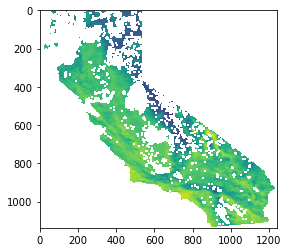

In [16]:
plt.imshow(LSTScaled)  # Visualize a basic plot of the scaled EVI data

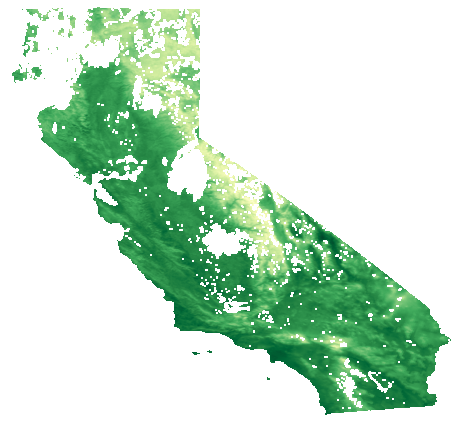

In [17]:
plt.figure(figsize = (10,7.5))    # Set the figure size (x,y)
plt.axis('off')                   # Remove the axes' values

# Plot the array, using a colormap and setting a custom linear stretch based on the min/max EVI values
plt.imshow(LSTScaled, vmin = np.nanmin(LSTScaled), vmax = np.nanmax(LSTScaled), cmap = 'YlGn');

# Cleaning Burned Area 

In [18]:
# Import libraries
import os
import glob
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt

In [19]:
# Set input directory, and change working directory
BAinDir = 'D:\Files\School\COMP_490_Senior_Design\Beat-the-Heat\Datasets\LST_BA'  # IMPORTANT: Update to reflect directory on your OS
os.chdir(BAinDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(BAinDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [20]:
BAFiles = glob.glob('MCD64A1.006_Burn_Date_**.tif') # Search for and create a list of BA files

In [21]:
print(len(BAFiles))

24


In [22]:
BA = gdal.Open(BAFiles[0])                    # Read file in, starting with MCD64A1 version 6
BABand = BA.GetRasterBand(1)                  # Read the band (layer)
BAData = BABand.ReadAsArray().astype('float') # Import band as an array with type float

In [23]:
print(BAFiles[0])

MCD64A1.006_Burn_Date_doy2019001_aid0001.tif


In [24]:
# File name metadata:
BAproductId = BAFiles[0].split('_')[0]                                          # First: product name
BAlayerId = BAFiles[0].split(BAproductId + '_')[1].split('_doy')[0]               # Second: layer name
BAyeardoy = BAFiles[0].split(BAlayerId+'_doy')[1].split('_aid')[0]                # Third: date
BAaid = BAFiles[0].split(BAyeardoy+'_')[1].split('.tif')[0]                       # Fourth: unique ROI identifier (aid)
BAdate = dt.datetime.strptime(BAyeardoy, '%Y%j').strftime('%m/%d/%Y')              # Convert YYYYDDD to MM/DD/YYYY
print('Product Name: {}\nLayer Name: {}\nDate of Observation: {}'.format(BAproductId, BAlayerId, BAdate))

Product Name: MCD64A1.006
Layer Name: Burn_Date
Date of Observation: 01/01/2019


In [25]:
# File Metadata
BA_meta = BA.GetMetadata()                   # Store metadata in dictionary
rows, cols = BA.RasterYSize, BA.RasterXSize  # Number of rows,columns

# Projection information
geotransform = BA.GetGeoTransform()
proj= BA.GetProjection() 

# Band metadata
BAFill = BABand.GetNoDataValue()            # Returns fill value
BAStats = BABand.GetStatistics(True, True)  # returns min, max, mean, and standard deviation
BA = None                                    # Close the GeoTIFF file
print('Min BA: {}\nMax BA: {}\nMean BA: {}\nSD BA: {}'.format(BAStats[0],BAStats[1], BAStats[2], BAStats[3]))

Min BA: -2.0
Max BA: 0.0
Mean BA: -0.088109405992274
SD BA: 0.41043336189964


In [26]:
scaleFactor = float(BA_meta['scale_factor'])  # Search the metadata dictionary for the scale factor 
units = BA_meta['units']                      # Search the metadata dictionary for the units
BAData[BAData == BAFill] = np.nan           # Set the fill value equal to NaN for the array
BAScaled = BAData * scaleFactor              # Apply the scale factor using simple multiplication

# Generate statistics on the scaled data
BAStats_sc = [np.nanmin(BAScaled), np.nanmax(BAScaled), np.nanmean(BAScaled), np.nanstd(BAScaled)] # Create a list of stats
print('Min BA: {}\nMax BA: {}\nMean BA: {}\nSD BA: {}'.format(BAStats_sc[0],BAStats_sc[1], BAStats_sc[2], BAStats_sc[3]))

Min BA: -2.0
Max BA: 20.0
Mean BA: -0.08483157396547111
SD BA: 0.40409342268530457


In [27]:
BAScaled

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [28]:
lut = glob.glob('MCD64A1-006-QA-lookup.csv')                                        # Search for look up table 
qualityFiles =glob.glob('MCD64A1.006_QA_**.tif')  # Search the directory for the associated quality .tifs
quality = gdal.Open(qualityFiles[0])                                   # Open the first quality file
qualityData = quality.GetRasterBand(1).ReadAsArray()                   # Read in as an array
quality = None 

In [29]:
v6_BAQA_lut = pd.read_csv(lut[0])     # Read in the lut
v6_BAQA_lut.head(11)  

,Value,Grid cell type,Special circumstances unburned,Valid data,Shortened mapping period,Grid cell relabeled algorithm,Spare
0,0,Water,"None or not applicable (i.e., burned, unmapped...",False,False,False,NaN
1,1,Land,"None or not applicable (i.e., burned, unmapped...",False,False,False,NaN
2,3,Land,"None or not applicable (i.e., burned, unmapped...",True,False,False,NaN
3,7,Land,"None or not applicable (i.e., burned, unmapped...",True,True,False,NaN
4,11,Land,"None or not applicable (i.e., burned, unmapped...",True,False,True,NaN
5,15,Land,"None or not applicable (i.e., burned, unmapped...",True,True,True,NaN
6,35,Land,Valid observations spaced too sparsely in time,True,False,False,NaN
7,67,Land,Too few training observations or insufficient ...,True,False,False,NaN
8,71,Land,Too few training observations or insufficient ...,True,True,False,NaN
9,99,Land,Apparent burn date at limits of time series,True,False,False,NaN


In [30]:
# Include good quality based on MODLAND
v6_BAQA_lut = v6_BAQA_lut[v6_BAQA_lut['Valid data'].isin([True])]

# Special circumstances unburned
SP =["Too few training observations or insufficient spectral separability between burned and unburned classes"]
v6_BAQA_lut = v6_BAQA_lut[~v6_BAQA_lut['Special circumstances unburned'].isin(SP)]

v6_BAQA_lut

,Value,Grid cell type,Special circumstances unburned,Valid data,Shortened mapping period,Grid cell relabeled algorithm,Spare
2,3,Land,"None or not applicable (i.e., burned, unmapped...",True,False,False,NaN
3,7,Land,"None or not applicable (i.e., burned, unmapped...",True,True,False,NaN
4,11,Land,"None or not applicable (i.e., burned, unmapped...",True,False,True,NaN
5,15,Land,"None or not applicable (i.e., burned, unmapped...",True,True,True,NaN
6,35,Land,Valid observations spaced too sparsely in time,True,False,False,NaN
9,99,Land,Apparent burn date at limits of time series,True,False,False,NaN
10,131,Land,"None or not applicable (i.e., burned, unmapped...",True,False,False,NaN


In [31]:
BAgoodQuality = list(v6_BAQA_lut['Value']) # Retrieve list of possible QA values from the quality dataframe
print(BAgoodQuality)

[3, 7, 11, 15, 35, 99, 131]


In [32]:
BA_masked = np.ma.MaskedArray(BAScaled, np.in1d(qualityData, BAgoodQuality, invert = True))    # Apply QA mask to the BA data

In [33]:
BAScaled.shape

(2276, 2485)

In [34]:
LST_masked.shape

(1138, 1243)

In [35]:
BA_resampled = scipy.ndimage.zoom(BA_masked,0.5, order=0) # Resample by a factor of 2 with nearest
new_col = np.sum(BA_resampled,1).reshape((BA_resampled.shape[0],1))
BA_resampled = np.append(BA_resampled,new_col,1)

In [36]:
LST_BA = np.ma.MaskedArray(LST_masked, np.in1d(BA_resampled, range(0,367), invert = True)) # Mask array, only include Croplands

In [37]:
BA_resampled.shape

(1138, 1243)

In [38]:
LST_masked.shape

(1138, 1243)

In [39]:
LST_BA

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [40]:
LST_BA.compressed()

array([269.84, 277.  , 276.72, ..., 290.34, 290.52, 290.58])

In [41]:
LST_BA.mean()

280.17090176425035